# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [14]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit,
                           plot_parameters_kde,
                           plot_sim_results,
                           plot_distance_weights)

In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [6]:
from channels.ikr_generic import ikr as model
model.sample({})

,x,y,exp
0,-80,0.002590,0
1,-70,0.022435,0
2,-60,0.099292,0
3,-50,0.356273,0
4,-40,1.115629,0
5,-30,3.026439,0
6,-20,6.702294,0
7,-10,11.179441,0
8,0,13.751745,0
9,10,13.387401,0


# Get experimental measurements

In [7]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [8]:
limits = dict(g_Kr=(0, 1),
              Vhalf_x=(-100,100),
              k_x=(0,50),
              c_bx=(0,200),
              c_ax=(0,1000),
              sigma_x=(0,100),
              Vmax_x=(-100,100),
              Vhalf_r=(-100,100),
              k_r=(-50,0),
              c_br=(0,100),
              c_ar=(0,100),
              sigma_r=(0,100),
              Vmax_r=(-100,100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [9]:
parameters = ['ikr.'+k for k in limits.keys()]

In [10]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

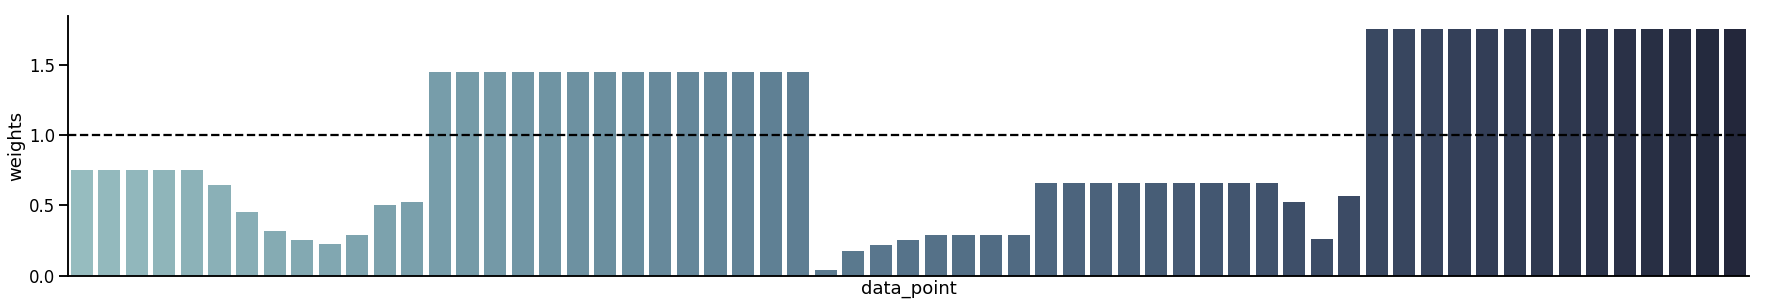

In [11]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)

In [12]:
g.savefig('results/ikr-generic/dist_weights.pdf')

In [15]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.05,
    n_samples=1000)

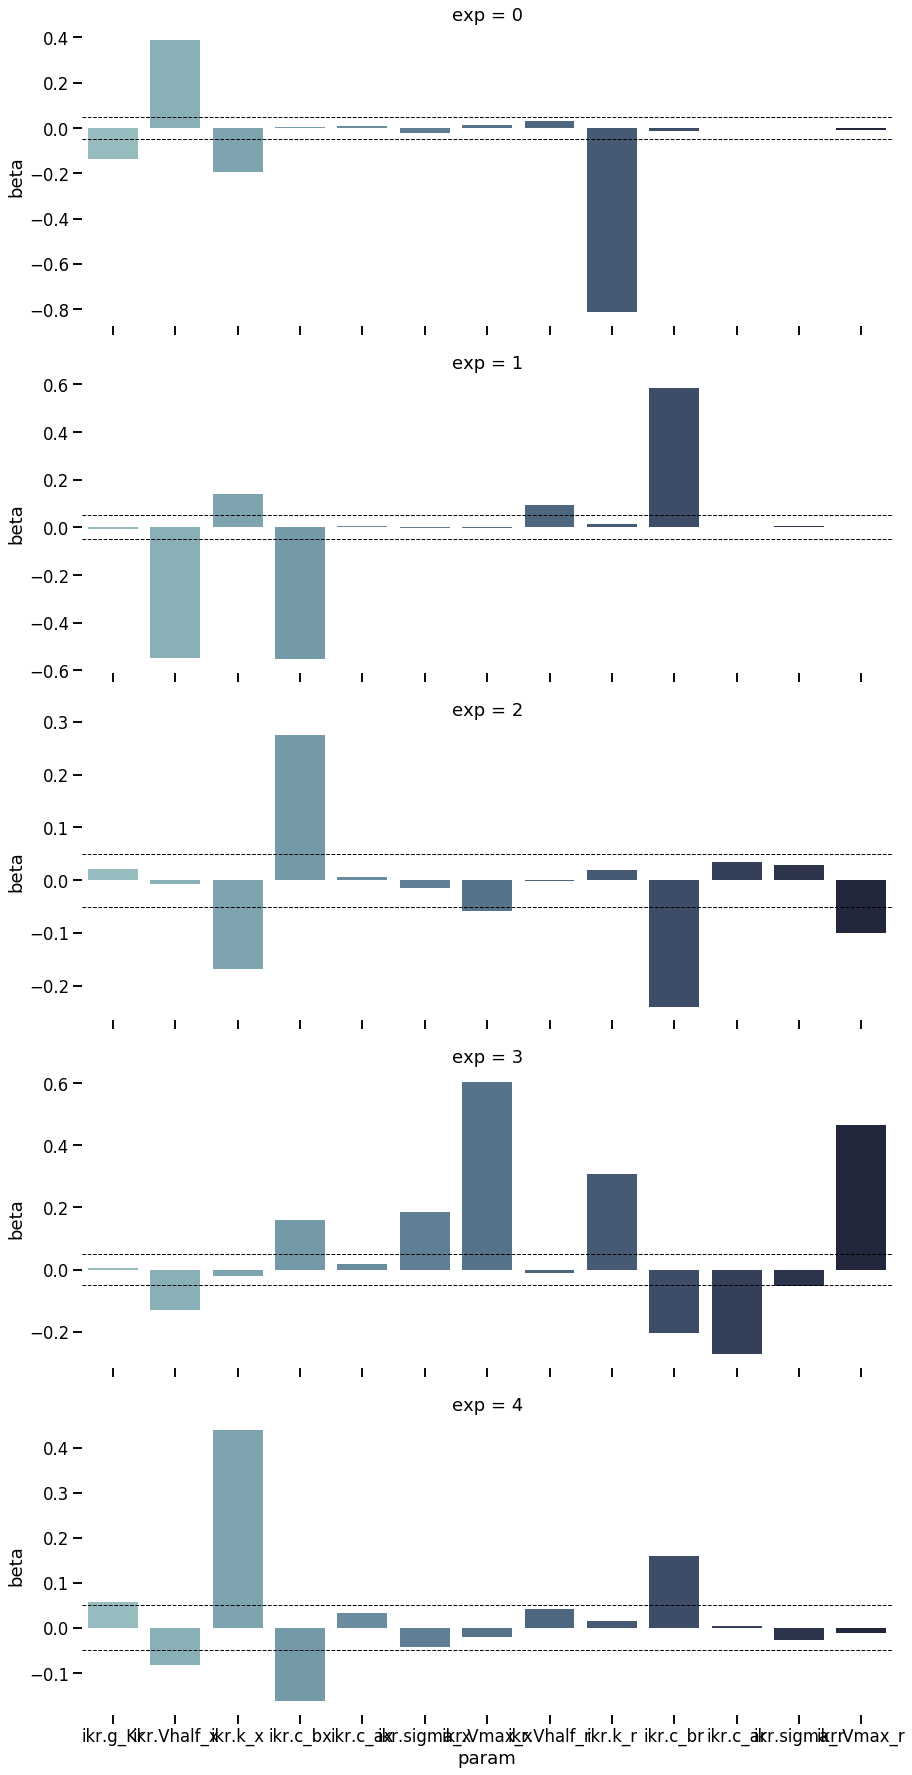

In [16]:
sns.set_context('talk')
grid1 = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

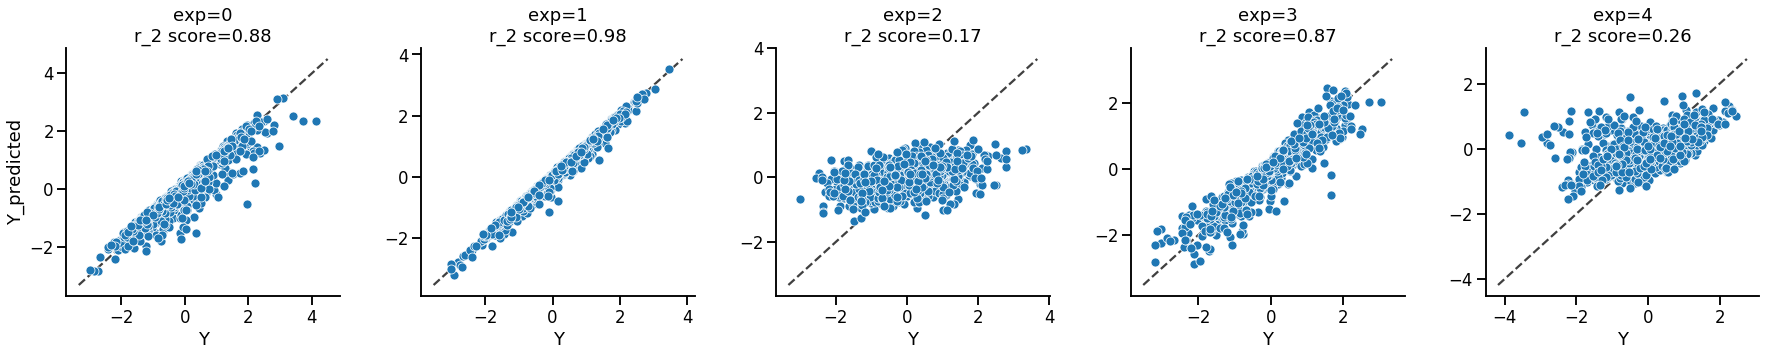

In [17]:
grid2 = plot_regression_fit(regression_fit, r2)

In [18]:
grid1.savefig('results/ikr-generic/sensitivity.pdf')
grid2.savefig('results/ikr-generic/sensitivity_fit.pdf')

In [19]:
# Finding insensitive parameters
cutoff = 0.05
fitted_pivot = fitted.pivot(index='param',columns='exp')
insensitive_params = fitted_pivot[(abs(fitted_pivot['beta'][0])<cutoff) & (abs(fitted_pivot['beta'][1])<cutoff) &
             (abs(fitted_pivot['beta'][2])<cutoff) & (abs(fitted_pivot['beta'][3])<cutoff) &
             (abs(fitted_pivot['beta'][4])<cutoff)].index.values

In [20]:
insensitive_limits = dict((k, limits[k[4:]]) for k in insensitive_params)
insensitive_prior = Distribution(**{key: RV("uniform", a, b - a)
                                 for key, (a,b) in insensitive_limits.items()})

In [21]:
# Generate random samples for insensitive parameters
def generate_sample(insensitive_prior, n):
    samples = [dict() for i in range(n)]
    for i in range(n):
        parameters = insensitive_prior.rvs()
        sample = {key: value for key, value in parameters.items()}
        samples[i].update(sample)
    return samples

In [22]:
samples = generate_sample(insensitive_prior, 1000)

In [23]:
model.add_external_par_samples(samples)

In [24]:
limits = dict((k, limits[k]) for k in limits if k[4:] not in insensitive_params)

In [25]:
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise database

In [26]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ikr-generic.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ikr-generic.db


In [27]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [28]:
from pyabc.populationstrategy import ConstantPopulationSize

In [29]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(2000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=1000,
             #    mean_cv=0.2,
             #    max_population_size=1000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.7487638473216004, 1: 0.7487638473216004, 2: 0.7487638473216004, 3: 0.7487638473216004, 4: 0.7487638473216004, 5: 0.6452126489868911, 6: 0.4540248441907876, 7: 0.31432950824375694, 8: 0.2527560988278615, 9: 0.22701001436964663, 10: 0.28843931278003027, 11: 0.5003539099245425, 12: 0.5216582794258379, 13: 1.447767207838316, 14: 1.447767207838316, 15: 1.447767207838316, 16: 1.447767207838316, 17: 1.447767207838316, 18: 1.447767207838316, 19: 1.447767207838316, 20: 1.447767207838316, 21: 1.447767207838316, 22: 1.447767207838316, 23: 1.447767207838316, 24: 1.447767207838316, 25: 1.447767207838316, 26: 1.447767207838316, 27: 0.04097751283384845, 28: 0.17269094694264644, 29: 0.21978847792700548, 30: 0.2544919218102176, 31: 0.28611517836651595, 32: 0.28611517836651595, 33: 0.28611517836651595, 34: 0.28611517836651595, 35: 0.6612823926919004, 36: 0.6612823926919004, 37: 0.6612823926919004, 38: 0.6612823926919004, 39: 0.6612823926919004, 40: 0.6612823926919004

In [30]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=11, start_time=2018-11-16 12:16:30.314764, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 104.65467830188523


In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:104.65467830188523
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 7022
DEBUG:Epsilon:new eps, t=1, eps=81.78480667653494
INFO:ABC:t:1 eps:81.78480667653494
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/smc.py:735: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
DEBUG:ABC:now s

In [22]:
abc_continued = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(2000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=1000,
             #    mean_cv=0.2,
             #    max_population_size=1000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

In [23]:
abc_continued.load(db_path, 9)

9

In [25]:
abc_continued.run(minimum_epsilon=0.05, max_nr_populations=30, min_acceptance_rate=0.01)

KeyboardInterrupt: 

# Results analysis

In [26]:
db_path = 'sqlite:////scratch/cph211/tmp/hl-1_ikr-generic.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-13 11:30:51.204713, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-11-13 13:21:12.657180, end_time=None)>,
 <ABCSMC(id=3, start_time=2018-11-14 09:38:41.548631, end_time=None)>,
 <ABCSMC(id=4, start_time=2018-11-14 10:04:53.528171, end_time=None)>,
 <ABCSMC(id=5, start_time=2018-11-14 10:14:26.229983, end_time=2018-11-14 15:41:35.538645)>,
 <ABCSMC(id=6, start_time=2018-11-14 15:57:29.872515, end_time=2018-11-14 22:46:00.760422)>,
 <ABCSMC(id=7, start_time=2018-11-15 09:01:45.886070, end_time=None)>,
 <ABCSMC(id=8, start_time=2018-11-15 09:09:36.373161, end_time=None)>,
 <ABCSMC(id=9, start_time=2018-11-15 09:11:56.842601, end_time=2018-11-16 10:48:28.649882)>]

In [27]:
history.id = 9

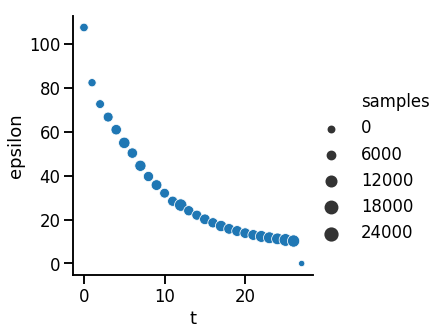

In [28]:
sns.set_context('talk')
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
#grid.savefig('results/ikr/eps_evolution.pdf')

In [32]:
df, w = history.get_distribution(m=0,t=26)

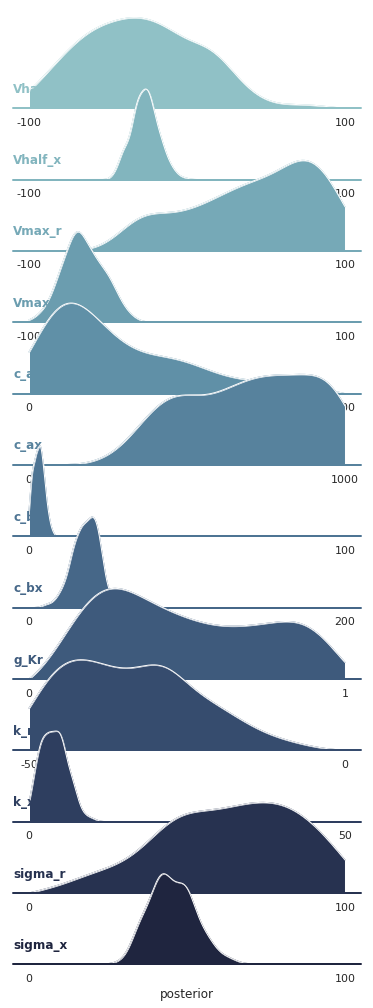

In [33]:
g = plot_parameters_kde(df, w, limits, aspect=5, height=1.1)

In [29]:
#g.savefig('results/ikr/parameters_kde.pdf')

# Samples for quantitative analysis

In [34]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [35]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)#, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

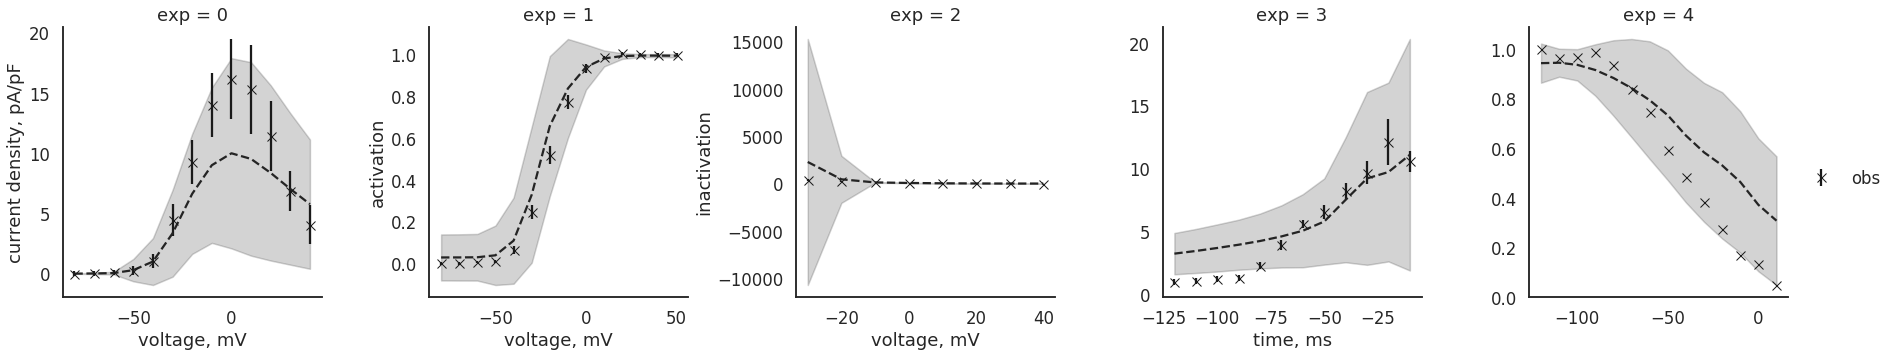

In [36]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "inactivation"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [41]:
g.savefig('results/ikr/ikr_sim_results.pdf')

In [45]:
# Activation fit to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [47]:
import scipy.stats as st
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -19.006959674154608
95% CI: (-23.690553929100158, -12.943008619235584)


In [49]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 8.143673554435612
95% CI: (6.999841088430485, 10.64641006169146)


In [54]:
# Inactivation fit to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-40, 30)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [58]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -35.41926532865971
95% CI: (-47.62120526011307, -20.219237796670395)


In [59]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 21.09252560793945
95% CI: (15.116458854568313, 32.265251891970216)
